#### Importing Libraries

In [10]:
import torch 
from torch import nn
import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import os
import random
device = "cuda" if torch.cuda.is_available() else "cpu"

### Getting Ready With Data


In [11]:
image_path = Path("data/")
train_dir = image_path/"train"
test_dir = image_path/"test"

### Random Image Check


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

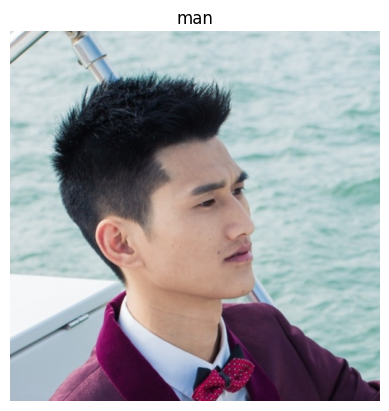

In [12]:

image_list = list(image_path.glob("*/*/*.jpg"))

random_image = random.choice(image_list)

t = random_image.parent.stem
random_image = Image.open(random_image)
plt.imshow(random_image)
plt.title(t)
plt.axis("off")

### Changing the image to Tensor

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])


# data_transform = transforms.Compose([
#     transforms.Resize(size=(224,224)),
#     transforms.TrivialAugmentWide(31),
#     transforms.ToTensor()
# ])


### Checking the transform on random image

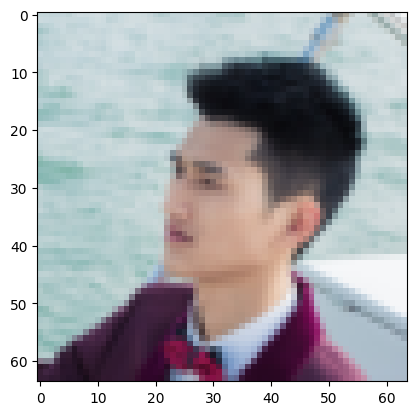

In [14]:
img_t = data_transform(random_image)
plt.imshow(img_t.permute(1,2,0))
plt.show()

### Compairing the Normal image with tranform image

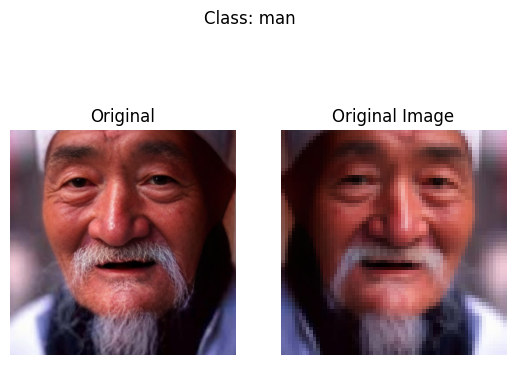

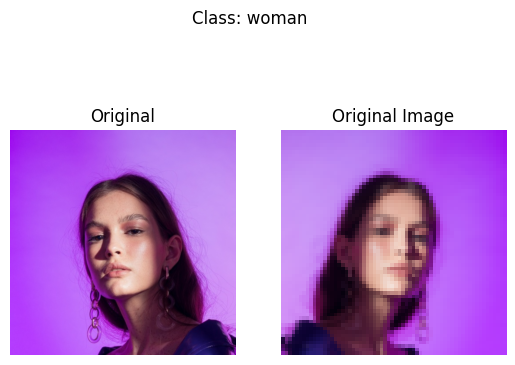

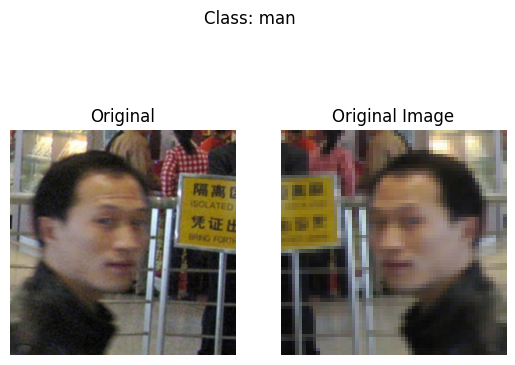

In [15]:
def plot_random(image_path_list,transform,n=3,seed=0):
    # sorted(image_path_list)
    if seed:
        random.seed(seed)
    random_image_paths = random.sample(image_path_list,k=n)

    for i in random_image_paths:
        # t = i.parent.stem
        with Image.open(i) as img:
            fig,ax = plt.subplots(nrows=1,ncols=2)
            ax[0].imshow(img)
            ax[0].set_title("Original")
            ax[0].axis("off")

            transform_img = transform(img)
            ax[1].imshow(transform_img.permute(1,2,0))
            ax[1].set_title("Original Image")
            ax[1].axis("off")

            fig.suptitle(f"Class: {i.parent.stem}")
    plt.show()


plot_random(image_list,data_transform,3)
# random_image

### Creating Dataset 

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

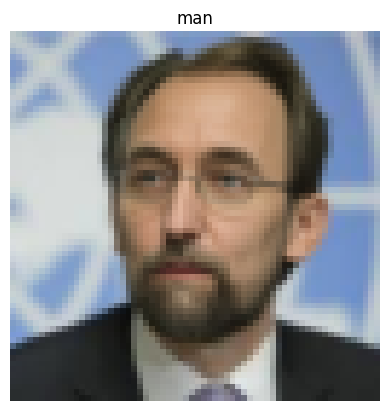

In [16]:
train_data = datasets.ImageFolder(root=train_dir,
                                 transform=data_transform,
                                 target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform,
                                 target_transform=None)


class_name = train_data.classes
img, label = train_data[0][0], train_data[0][1]

plt.imshow(img.permute(1,2,0))
plt.title(class_name[label])
plt.axis("off")

### Creating Dataloder for the model

In [17]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=32,
                              shuffle=False,
                              num_workers=os.cpu_count())

len(train_dataloader),len(test_dataloader)

(389, 49)

In [18]:
train_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor()
])


class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,out_features=output_shape)
        )
    def forward(self,x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x
        # return self.classifer(self.conv_block_2(self.conv_block_1(x))) #? operator fusion

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(class_name)).to(device)
model_0

 #? Train step()

def train_step(model,dataloader,loss_fn,optimizer):
    model.train()

    # Setup train loss and acc

    train_loss, train_acc = 0,0;

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device),y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred,y)

        train_loss+=loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #calc acc

        y_pred_class = torch.argmax(torch.softmax(y_pred,dim=1),dim=1)

        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    tran_loss = train_loss/len(dataloader)
    train_acc = train_acc/len(dataloader)
    return train_loss,train_acc

 #? Test step()

def test_step(model, dataloader, loss_fn):
    model.eval()

    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class == y).sum().item() / len(y_pred)

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    
    return test_loss, test_acc
from tqdm.auto import tqdm

def train(model, train_dataloader, test_dataloader, optimizer, loss_fn, epochs=5, device="cpu"):
    results = {"Train_loss": [],
               "Train_Acc": [],
               "test_loss": [],
               "test_acc": []}
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model, 
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer)
        
        test_loss, test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn)

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f}")
        
        results["Train_loss"].append(train_loss)
        results["Train_Acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

import torch.optim.adam
train_data_simple = datasets.ImageFolder(root=train_dir,
                             transform=train_transform)

test_data_simple = datasets.ImageFolder(root=test_dir,
                             transform=test_transform)

#? Train dataset into loadert

BATCH_SIZE = 32
NUM_WORK = 16

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORK,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORK,
                                     shuffle=False)

torch.manual_seed(42)

NUM_EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(),lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model_0,train_dataloader,test_dataloader,optimizer,loss_fn,NUM_EPOCHS,device)

end = timer()

print(f"Total time:{end - start_time:.3f}Seconds \n")
model_0_results





c:\Users\speci\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 20%|██        | 1/5 [01:55<07:43, 115.82s/it]

Epoch: 1 | train_loss: 203.7197 | train_acc: 0.7307 | test_loss: 0.4461 | test_acc: 0.7941


 40%|████      | 2/5 [03:52<05:49, 116.40s/it]

Epoch: 2 | train_loss: 165.2329 | train_acc: 0.8069 | test_loss: 0.4324 | test_acc: 0.7959


 60%|██████    | 3/5 [05:53<03:56, 118.24s/it]

Epoch: 3 | train_loss: 152.3703 | train_acc: 0.8246 | test_loss: 0.3933 | test_acc: 0.8323


 80%|████████  | 4/5 [08:00<02:01, 121.87s/it]

Epoch: 4 | train_loss: 142.1318 | train_acc: 0.8347 | test_loss: 0.3630 | test_acc: 0.8355


100%|██████████| 5/5 [09:57<00:00, 119.49s/it]

Epoch: 5 | train_loss: 133.9508 | train_acc: 0.8499 | test_loss: 0.3192 | test_acc: 0.8673
Total time:597.452Seconds 



### Plotting Loss Curves of the Model


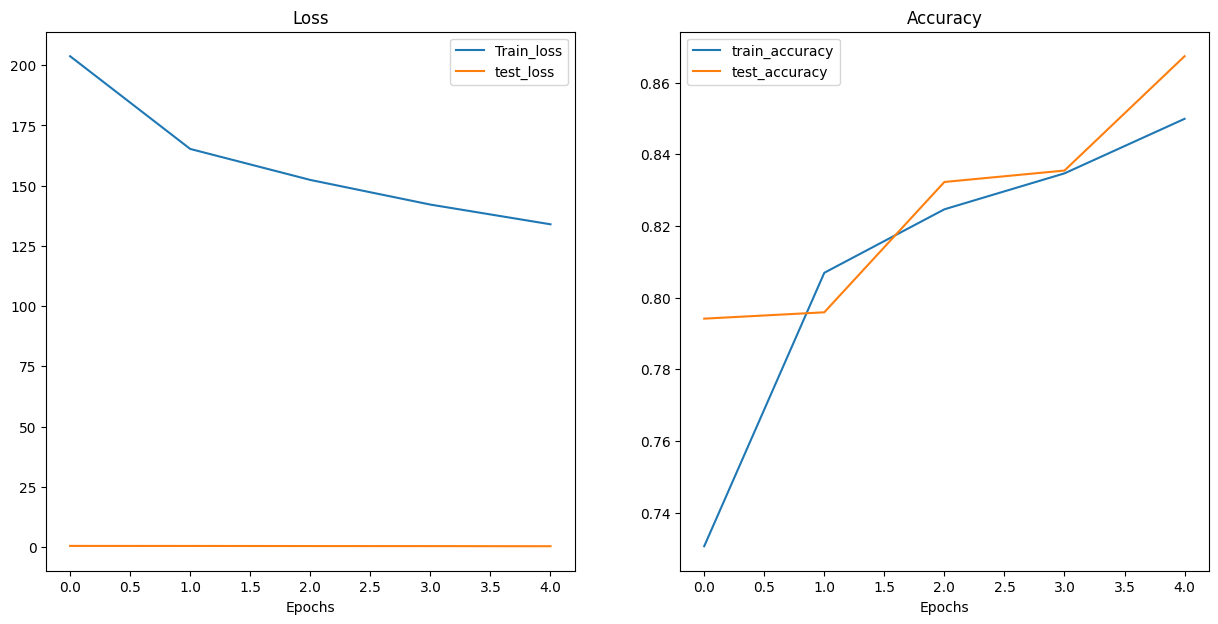

In [19]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    
    Args:
        results (dict): Dictionary containing lists of values, specifically:
            - train_loss
            - train_acc
            - test_loss
            - test_acc
    """
    loss = results['Train_loss']
    test_loss = results['test_loss']

    accuracy = results['Train_Acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['Train_loss']))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
plot_loss_curves(model_0_results)

### Saving the model


In [ ]:
import os
if not os.path.exists('model'):
    os.makedirs('model')

torch.save(model_0.state_dict(), 'model/model_0.pth')
print("Model saved successfully to 'model/model_0.pth'")

### Predecting random images with the model

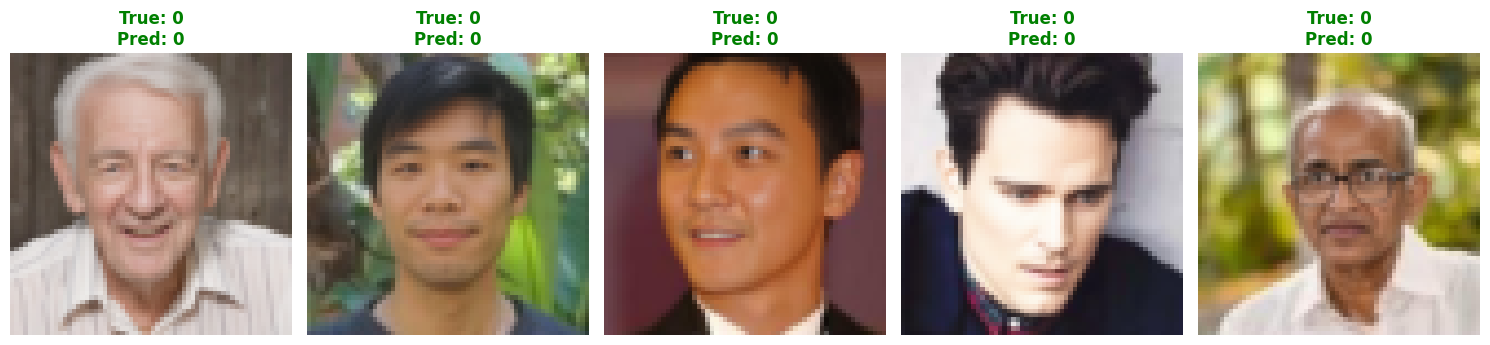

In [24]:
import random
import matplotlib.pyplot as plt
import numpy as np

def get_random_test_samples(test_dataloader, num_samples=10):
    test_batch = next(iter(test_dataloader))
    test_images, test_labels = test_batch
    
    random_indices = random.sample(range(len(test_images)), min(num_samples, len(test_images)))
    
    random_images = test_images[random_indices]
    random_labels = test_labels[random_indices]
    
    return random_images, random_labels

model_0.eval()

random_images, random_labels = get_random_test_samples(test_dataloader, num_samples=5)

with torch.no_grad():
    random_images = random_images.to(next(model_0.parameters()).device)
    
    pred_logits = model_0(random_images)
    pred_probs = torch.softmax(pred_logits, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

random_images = random_images.cpu()
random_labels = random_labels.cpu()
pred_labels = pred_labels.cpu()

plt.figure(figsize=(15, 10))
for i, (image, true_label, pred_label) in enumerate(zip(random_images, random_labels, pred_labels)):
    plt.subplot(1, 5, i+1)
    img = image.permute(1, 2, 0).numpy()
    
    if img.max() > 1.0:
        img = img / 255.0
    
    plt.imshow(img)
    
    correct = true_label.item() == pred_label.item()
    color = 'green' if correct else 'red'
    
    plt.title(f"True: {true_label.item()}\nPred: {pred_label.item()}", 
              color=color, fontweight='bold')
    
    if not correct:
        plt.gca().spines['top'].set_color('red')
        plt.gca().spines['bottom'].set_color('red')
        plt.gca().spines['left'].set_color('red')
        plt.gca().spines['right'].set_color('red')
        plt.gca().spines['top'].set_linewidth(3)
        plt.gca().spines['bottom'].set_linewidth(3)
        plt.gca().spines['left'].set_linewidth(3)
        plt.gca().spines['right'].set_linewidth(3)
    
    plt.axis("off")
plt.tight_layout()
plt.show()


In [23]:
from torchinfo import summary

summary(model_0,input_size=[1,3,64,64])


Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 2]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia